In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import random

In [108]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # Set seed for PyTorch
    np.random.seed(seed)  # Set seed for NumPy
    random.seed(seed)  # Set seed for Python's random module

    # Ensure reproducibility for GPU (MPS for Mac)
    torch.mps.manual_seed(seed)  # For MPS (Metal on Mac)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed
set_seed(42)

### Load Model

In [109]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    # print(model)
    return model


### Functions

In [111]:
class OCTTestDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        
        # self.img_names = [f for f in os.listdir(folder_path) if f.endswith(".png")]
        self.img_names = [f for f in os.listdir(folder_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        print("Files loaded into dataset:")
        for f in self.img_names:
            print(f)

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Match VGG16 input
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.folder_path, img_name)
        try:
            img = Image.open(img_path).convert("L")
        except Exception as e:
            print(f"Error loading image: {img_path}\n{e}")
            raise e
        return self.transform(img), img_name


def preprocess_image(folder_path, batch_size=16):
    dataset = OCTTestDataset(folder_path)
    print(f"Total images: {len(dataset)}")
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Custom dataset class
# class ImageDataset(Dataset):
#     def __init__(self, image_path, transform=None):
#         self.image_paths = []
#         self.file_names = []
#         self.transform = transform

#         for root, _, files in os.walk(image_path):
#             for file in files:
#                 if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
#                     self.image_paths.append(os.path.join(root, file))
#                     self.file_names.append(file)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         file_name = self.file_names[idx]

#         image = Image.open(image_path).convert("RGB")  # Convert to grayscale

#         if self.transform:
#             image = self.transform(image)

#         return image, file_name  # Return both image tensor & filename
  
# def get_transforms(train=False):
#     if train:
#         return transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomRotation(degrees=(-10, 10)),
#             transforms.ToTensor()
#         ])
#     else:
#         return transforms.Compose([
#             transforms.Grayscale(num_output_channels=3),
#             transforms.Resize((224, 224)),
#             transforms.ToTensor()
#         ])


# # Preprocess images & return DataLoader
# def preprocess_image(image_path, batch_size=16, train=False):
#     transform = get_transforms(train=train)
#     dataset = ImageDataset(image_path, transform=transform)
#     print(f"Total images: {len(dataset)}")
#     test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#     return test_loader


In [112]:
def model_prediction(model, test_loader, save_txt_path, source_dir, dest_dir):
    # Open file for writing predictions
    dest_dir_fovea = dest_dir+"predictions/fovea"
    dest_dir_no_fovea = dest_dir+"predictions/no_fovea"
    os.makedirs(dest_dir_fovea, exist_ok=True)
    os.makedirs(dest_dir_no_fovea, exist_ok=True)

    with torch.no_grad(), open(save_txt_path, "w") as f: # changed to "w" from "a" ; this is to overwrite the old file and help maintain the latest copy of the classification output
        for images, filenames in tqdm(test_loader):
            images = images.to(device)  

            # Model inference
            outputs = model(images)
            # predicted_labels = torch.sigmoid(outputs).round().int()  # Convert logits to binary labels
            # predicted_labels = 1 - predicted_labels  # Invert class: 1 becomes 0, 0 becomes 1
            predicted_labels = 1 - torch.sigmoid(outputs).round().int()  # Invert: 1 becomes 0, 0 becomes 1

            # Save results
            fovea = 0

            for filename, label in zip(filenames, predicted_labels.cpu().numpy()):
                f.write(f"{filename} {label}\n")
                src_path = os.path.join(source_dir, filename)
                if label == 1:
                    dest_path = os.path.join(dest_dir_fovea, filename)
                    fovea += 1
                else:
                    dest_path = os.path.join(dest_dir_no_fovea, filename)
                shutil.copy(src_path, dest_path)

            print(f"Batch Summary: fovea {fovea} images")


def show_result(volume_path, save_txt_path, max_images=20):
    # Read the saved text file
    with open(save_txt_path, "r") as f:
        class_1_images = [line.rsplit(maxsplit=1) for line in f.readlines()]

    # Function to extract sequence number from img_name
    def extract_serial_number(img_name):
        return img_name.split("_")[-1].split(".")[0]

    # Filter: only images predicted as class 1
    class_1 = [(img_name, extract_serial_number(img_name)) 
               for img_name, label in class_1_images 
               if int(label.strip("[]")) == 1]

    num_images_to_show = min(len(class_1), max_images)
    if num_images_to_show == 0:
        print("No images classified as fovea (label 1) to display.")
        return

    images_per_row = 5
    num_rows = math.ceil(num_images_to_show / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))
    axes = axes.flatten()

    for idx, (img_name, serial_number) in enumerate(class_1[:num_images_to_show]):
        img = Image.open(os.path.join(volume_path, img_name))
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis("off")
        axes[idx].set_title(f"SN: {serial_number}")

    # Hide unused subplots
    for idx in range(num_images_to_show, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


Files loaded into dataset:
1003_left_bscan_073.png
1003_right_bscan_074.png
1004_left_bscan_070.png
1004_left_bscan_071.png
1007_right_bscan_059.png
1007_right_bscan_060.png
1007_right_bscan_061.png
1007_right_bscan_062.png
1007_right_bscan_064.png
1007_right_bscan_067.png
1007_right_bscan_068.png
2002000077_20221104_83000_OS_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg
3003000002_20140204_161923_R_Carl Zeiss Meditec_4000_512x1024x128_ORG_IMG_JPG_064.jpg
3003000002_20230612_90600_R_Carl Zeiss Meditec_5000_512x1024x128_ORG_IMG_JPG_072.jpg
RID_1001001769_20191022_163949_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg
Total images: 15
Saving results at: predictions/potentially_fovea/class_1_predictions_potentially_fovea.txt


  7%|▋         | 1/15 [00:00<00:01,  7.04it/s]

Batch Summary: fovea 1 images


 13%|█▎        | 2/15 [00:00<00:01,  7.87it/s]

Batch Summary: fovea 1 images


 20%|██        | 3/15 [00:00<00:01,  7.03it/s]

Batch Summary: fovea 1 images


 27%|██▋       | 4/15 [00:00<00:01,  7.19it/s]

Batch Summary: fovea 1 images


 33%|███▎      | 5/15 [00:00<00:01,  7.57it/s]

Batch Summary: fovea 1 images


 40%|████      | 6/15 [00:00<00:01,  7.77it/s]

Batch Summary: fovea 1 images


 47%|████▋     | 7/15 [00:00<00:01,  7.87it/s]

Batch Summary: fovea 1 images


 53%|█████▎    | 8/15 [00:01<00:00,  7.96it/s]

Batch Summary: fovea 1 images


 60%|██████    | 9/15 [00:01<00:00,  7.67it/s]

Batch Summary: fovea 1 images


 67%|██████▋   | 10/15 [00:01<00:00,  7.28it/s]

Batch Summary: fovea 1 images


 73%|███████▎  | 11/15 [00:01<00:00,  7.00it/s]

Batch Summary: fovea 1 images


 80%|████████  | 12/15 [00:01<00:00,  7.02it/s]

Batch Summary: fovea 0 images


 87%|████████▋ | 13/15 [00:01<00:00,  7.07it/s]

Batch Summary: fovea 1 images


 93%|█████████▎| 14/15 [00:01<00:00,  6.87it/s]

Batch Summary: fovea 0 images


100%|██████████| 15/15 [00:02<00:00,  7.35it/s]

Batch Summary: fovea 0 images


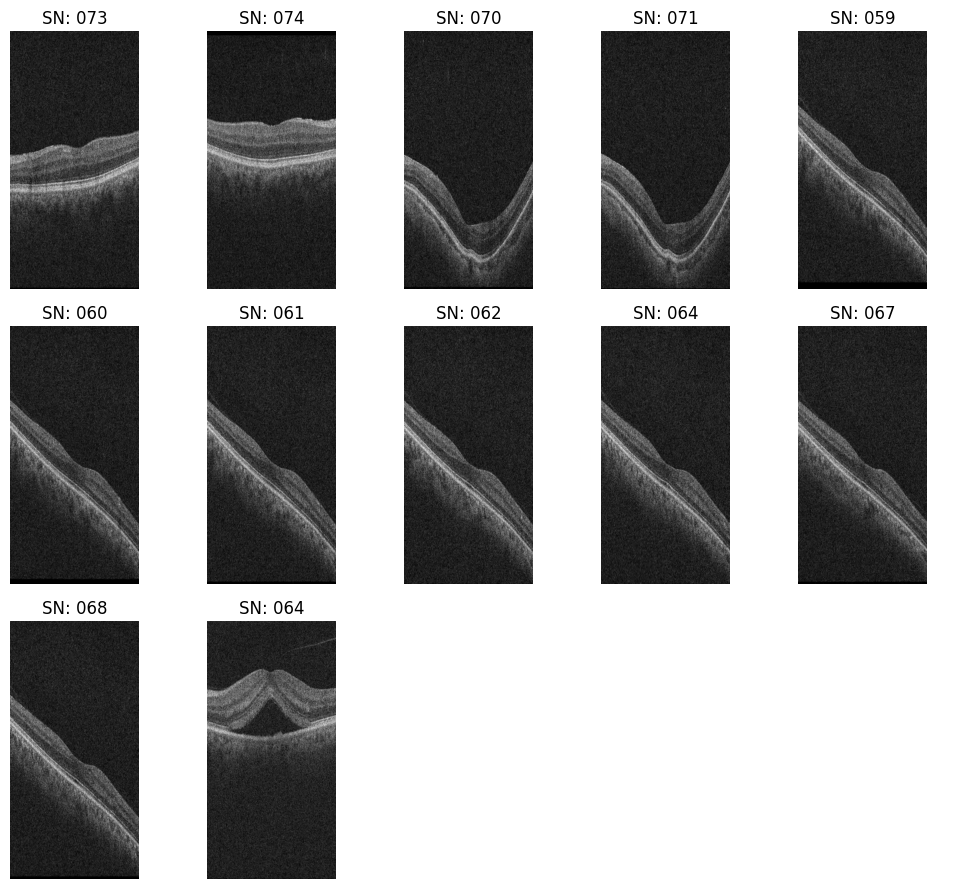

Files loaded into dataset:
1004_left_bscan_058.png
1004_left_bscan_059.png
1004_left_bscan_060.png
1004_left_bscan_061.png
1004_right_bscan_056.png
1004_right_bscan_057.png
1004_right_bscan_058.png
1004_right_bscan_059.png
1004_right_bscan_060.png
1004_right_bscan_072.png
1004_right_bscan_073.png
1004_right_bscan_074.png
1004_right_bscan_075.png
1004_right_bscan_076.png
1004_right_bscan_077.png
1004_right_bscan_078.png
1004_right_bscan_080.png
1005_left_bscan_048.png
1005_left_bscan_049.png
1005_left_bscan_050.png
1005_left_bscan_051.png
1005_left_bscan_052.png
1005_left_bscan_053.png
1005_left_bscan_073.png
1005_left_bscan_074.png
1005_left_bscan_075.png
1005_left_bscan_076.png
1005_left_bscan_077.png
1006_left_bscan_053.png
1006_left_bscan_054.png
1006_left_bscan_055.png
1006_left_bscan_072.png
1012_right_bscan_057.png
1012_right_bscan_058.png
1012_right_bscan_059.png
1013_left_bscan_047.png
1013_left_bscan_048.png
1013_left_bscan_071.png
1013_left_bscan_072.png
1013_left_bscan_073.p

  1%|          | 1/117 [00:00<00:19,  6.09it/s]

Batch Summary: fovea 0 images


  2%|▏         | 2/117 [00:00<00:16,  7.08it/s]

Batch Summary: fovea 0 images


  3%|▎         | 3/117 [00:00<00:15,  7.21it/s]

Batch Summary: fovea 0 images


  3%|▎         | 4/117 [00:00<00:16,  7.03it/s]

Batch Summary: fovea 0 images


  4%|▍         | 5/117 [00:00<00:15,  7.42it/s]

Batch Summary: fovea 0 images


  5%|▌         | 6/117 [00:00<00:15,  7.38it/s]

Batch Summary: fovea 0 images


  6%|▌         | 7/117 [00:00<00:15,  7.09it/s]

Batch Summary: fovea 0 images


  7%|▋         | 8/117 [00:01<00:14,  7.41it/s]

Batch Summary: fovea 0 images


  8%|▊         | 9/117 [00:01<00:14,  7.52it/s]

Batch Summary: fovea 0 images


  9%|▊         | 10/117 [00:01<00:13,  7.73it/s]

Batch Summary: fovea 0 images


  9%|▉         | 11/117 [00:01<00:13,  7.66it/s]

Batch Summary: fovea 0 images


 10%|█         | 12/117 [00:01<00:13,  7.85it/s]

Batch Summary: fovea 0 images


 11%|█         | 13/117 [00:01<00:13,  7.92it/s]

Batch Summary: fovea 0 images


 12%|█▏        | 14/117 [00:01<00:12,  7.94it/s]

Batch Summary: fovea 0 images


 13%|█▎        | 15/117 [00:01<00:12,  7.95it/s]

Batch Summary: fovea 0 images


 14%|█▎        | 16/117 [00:02<00:12,  7.90it/s]

Batch Summary: fovea 0 images


 15%|█▍        | 17/117 [00:02<00:13,  7.30it/s]

Batch Summary: fovea 0 images


 15%|█▌        | 18/117 [00:02<00:13,  7.31it/s]

Batch Summary: fovea 0 images


 16%|█▌        | 19/117 [00:02<00:13,  7.37it/s]

Batch Summary: fovea 0 images


 17%|█▋        | 20/117 [00:02<00:12,  7.63it/s]

Batch Summary: fovea 0 images


 18%|█▊        | 21/117 [00:02<00:13,  7.35it/s]

Batch Summary: fovea 0 images


 19%|█▉        | 22/117 [00:02<00:13,  7.20it/s]

Batch Summary: fovea 0 images


 20%|█▉        | 23/117 [00:03<00:12,  7.53it/s]

Batch Summary: fovea 0 images


 21%|██        | 24/117 [00:03<00:12,  7.55it/s]

Batch Summary: fovea 0 images


 21%|██▏       | 25/117 [00:03<00:12,  7.49it/s]

Batch Summary: fovea 0 images


 22%|██▏       | 26/117 [00:03<00:12,  7.20it/s]

Batch Summary: fovea 0 images


 23%|██▎       | 27/117 [00:03<00:12,  7.24it/s]

Batch Summary: fovea 0 images


 24%|██▍       | 28/117 [00:03<00:12,  7.08it/s]

Batch Summary: fovea 0 images


 25%|██▍       | 29/117 [00:03<00:12,  7.20it/s]

Batch Summary: fovea 0 images


 26%|██▌       | 30/117 [00:04<00:11,  7.27it/s]

Batch Summary: fovea 0 images


 26%|██▋       | 31/117 [00:04<00:11,  7.35it/s]

Batch Summary: fovea 0 images


 27%|██▋       | 32/117 [00:04<00:12,  6.97it/s]

Batch Summary: fovea 0 images


 28%|██▊       | 33/117 [00:04<00:12,  6.73it/s]

Batch Summary: fovea 0 images


 29%|██▉       | 34/117 [00:04<00:11,  7.15it/s]

Batch Summary: fovea 0 images


 30%|██▉       | 35/117 [00:04<00:11,  7.17it/s]

Batch Summary: fovea 0 images


 31%|███       | 36/117 [00:04<00:11,  7.04it/s]

Batch Summary: fovea 0 images


 32%|███▏      | 37/117 [00:05<00:12,  6.27it/s]

Batch Summary: fovea 0 images


 32%|███▏      | 38/117 [00:05<00:11,  6.78it/s]

Batch Summary: fovea 0 images


 33%|███▎      | 39/117 [00:05<00:11,  6.93it/s]

Batch Summary: fovea 0 images


 34%|███▍      | 40/117 [00:05<00:11,  6.92it/s]

Batch Summary: fovea 0 images


 35%|███▌      | 41/117 [00:05<00:10,  7.28it/s]

Batch Summary: fovea 0 images


 36%|███▌      | 42/117 [00:05<00:10,  7.27it/s]

Batch Summary: fovea 0 images


 37%|███▋      | 43/117 [00:05<00:10,  6.89it/s]

Batch Summary: fovea 0 images


 38%|███▊      | 44/117 [00:06<00:10,  6.98it/s]

Batch Summary: fovea 0 images


 38%|███▊      | 45/117 [00:06<00:10,  6.65it/s]

Batch Summary: fovea 0 images


 39%|███▉      | 46/117 [00:06<00:10,  7.05it/s]

Batch Summary: fovea 0 images


 40%|████      | 47/117 [00:06<00:09,  7.14it/s]

Batch Summary: fovea 0 images


 41%|████      | 48/117 [00:06<00:09,  7.34it/s]

Batch Summary: fovea 0 images


 42%|████▏     | 49/117 [00:06<00:09,  7.05it/s]

Batch Summary: fovea 0 images


 43%|████▎     | 50/117 [00:06<00:09,  7.22it/s]

Batch Summary: fovea 0 images


 44%|████▎     | 51/117 [00:07<00:09,  6.90it/s]

Batch Summary: fovea 0 images


 44%|████▍     | 52/117 [00:07<00:10,  6.23it/s]

Batch Summary: fovea 0 images


 45%|████▌     | 53/117 [00:07<00:09,  6.73it/s]

Batch Summary: fovea 0 images


 46%|████▌     | 54/117 [00:07<00:09,  6.92it/s]

Batch Summary: fovea 0 images


 47%|████▋     | 55/117 [00:07<00:08,  6.89it/s]

Batch Summary: fovea 0 images


 48%|████▊     | 56/117 [00:07<00:09,  6.45it/s]

Batch Summary: fovea 0 images


 49%|████▊     | 57/117 [00:08<00:09,  6.23it/s]

Batch Summary: fovea 0 images


 50%|████▉     | 58/117 [00:08<00:09,  6.46it/s]

Batch Summary: fovea 0 images


 50%|█████     | 59/117 [00:08<00:09,  6.21it/s]

Batch Summary: fovea 0 images


 51%|█████▏    | 60/117 [00:08<00:08,  6.52it/s]

Batch Summary: fovea 0 images


 52%|█████▏    | 61/117 [00:08<00:08,  6.59it/s]

Batch Summary: fovea 0 images


 53%|█████▎    | 62/117 [00:08<00:08,  6.37it/s]

Batch Summary: fovea 0 images


 54%|█████▍    | 63/117 [00:08<00:08,  6.41it/s]

Batch Summary: fovea 0 images


 55%|█████▍    | 64/117 [00:09<00:07,  6.79it/s]

Batch Summary: fovea 0 images


 56%|█████▌    | 65/117 [00:09<00:07,  6.97it/s]

Batch Summary: fovea 0 images


 56%|█████▋    | 66/117 [00:09<00:07,  7.08it/s]

Batch Summary: fovea 0 images


 57%|█████▋    | 67/117 [00:09<00:06,  7.18it/s]

Batch Summary: fovea 0 images


 58%|█████▊    | 68/117 [00:09<00:06,  7.45it/s]

Batch Summary: fovea 0 images


 59%|█████▉    | 69/117 [00:09<00:06,  7.72it/s]

Batch Summary: fovea 0 images


 60%|█████▉    | 70/117 [00:09<00:06,  7.36it/s]

Batch Summary: fovea 0 images


 61%|██████    | 71/117 [00:10<00:07,  6.40it/s]

Batch Summary: fovea 0 images


 62%|██████▏   | 72/117 [00:10<00:07,  6.38it/s]

Batch Summary: fovea 0 images


 62%|██████▏   | 73/117 [00:10<00:06,  6.38it/s]

Batch Summary: fovea 0 images


 63%|██████▎   | 74/117 [00:10<00:06,  6.50it/s]

Batch Summary: fovea 0 images


 64%|██████▍   | 75/117 [00:10<00:06,  6.43it/s]

Batch Summary: fovea 0 images


 65%|██████▍   | 76/117 [00:10<00:06,  6.57it/s]

Batch Summary: fovea 0 images


 66%|██████▌   | 77/117 [00:10<00:06,  6.62it/s]

Batch Summary: fovea 0 images


 67%|██████▋   | 78/117 [00:11<00:05,  6.87it/s]

Batch Summary: fovea 0 images


 68%|██████▊   | 79/117 [00:11<00:05,  7.07it/s]

Batch Summary: fovea 0 images


 68%|██████▊   | 80/117 [00:11<00:05,  7.00it/s]

Batch Summary: fovea 0 images


 69%|██████▉   | 81/117 [00:11<00:05,  6.73it/s]

Batch Summary: fovea 0 images


 70%|███████   | 82/117 [00:11<00:05,  6.63it/s]

Batch Summary: fovea 0 images


 71%|███████   | 83/117 [00:11<00:05,  6.43it/s]

Batch Summary: fovea 0 images


 72%|███████▏  | 84/117 [00:12<00:05,  6.58it/s]

Batch Summary: fovea 0 images


 73%|███████▎  | 85/117 [00:12<00:04,  6.74it/s]

Batch Summary: fovea 1 images


 74%|███████▎  | 86/117 [00:12<00:04,  7.05it/s]

Batch Summary: fovea 0 images


 74%|███████▍  | 87/117 [00:12<00:04,  7.00it/s]

Batch Summary: fovea 1 images


 75%|███████▌  | 88/117 [00:12<00:04,  6.98it/s]

Batch Summary: fovea 0 images


 76%|███████▌  | 89/117 [00:12<00:04,  6.96it/s]

Batch Summary: fovea 0 images


 77%|███████▋  | 90/117 [00:12<00:04,  6.33it/s]

Batch Summary: fovea 1 images


 78%|███████▊  | 91/117 [00:13<00:03,  6.51it/s]

Batch Summary: fovea 0 images


 79%|███████▊  | 92/117 [00:13<00:03,  6.64it/s]

Batch Summary: fovea 0 images


 79%|███████▉  | 93/117 [00:13<00:03,  6.53it/s]

Batch Summary: fovea 0 images


 80%|████████  | 94/117 [00:13<00:03,  6.51it/s]

Batch Summary: fovea 0 images


 81%|████████  | 95/117 [00:13<00:03,  6.83it/s]

Batch Summary: fovea 0 images


 82%|████████▏ | 96/117 [00:13<00:03,  6.88it/s]

Batch Summary: fovea 0 images


 83%|████████▎ | 97/117 [00:13<00:02,  7.13it/s]

Batch Summary: fovea 0 images


 84%|████████▍ | 98/117 [00:14<00:02,  6.87it/s]

Batch Summary: fovea 0 images


 85%|████████▍ | 99/117 [00:14<00:02,  6.75it/s]

Batch Summary: fovea 0 images


 85%|████████▌ | 100/117 [00:14<00:02,  6.95it/s]

Batch Summary: fovea 0 images


 86%|████████▋ | 101/117 [00:14<00:02,  6.93it/s]

Batch Summary: fovea 0 images


 87%|████████▋ | 102/117 [00:14<00:02,  6.27it/s]

Batch Summary: fovea 0 images


 88%|████████▊ | 103/117 [00:14<00:02,  6.66it/s]

Batch Summary: fovea 0 images


 89%|████████▉ | 104/117 [00:14<00:01,  6.96it/s]

Batch Summary: fovea 0 images


 90%|████████▉ | 105/117 [00:15<00:01,  7.30it/s]

Batch Summary: fovea 0 images


 91%|█████████ | 106/117 [00:15<00:01,  7.53it/s]

Batch Summary: fovea 0 images


 91%|█████████▏| 107/117 [00:15<00:01,  7.57it/s]

Batch Summary: fovea 0 images


 92%|█████████▏| 108/117 [00:15<00:01,  7.17it/s]

Batch Summary: fovea 0 images


 93%|█████████▎| 109/117 [00:15<00:01,  6.36it/s]

Batch Summary: fovea 0 images


 94%|█████████▍| 110/117 [00:15<00:01,  6.54it/s]

Batch Summary: fovea 0 images


 95%|█████████▍| 111/117 [00:15<00:00,  7.01it/s]

Batch Summary: fovea 0 images


 96%|█████████▌| 112/117 [00:16<00:00,  7.17it/s]

Batch Summary: fovea 0 images


 97%|█████████▋| 113/117 [00:16<00:00,  7.09it/s]

Batch Summary: fovea 0 images


 97%|█████████▋| 114/117 [00:16<00:00,  6.89it/s]

Batch Summary: fovea 0 images


 98%|█████████▊| 115/117 [00:16<00:00,  7.07it/s]

Batch Summary: fovea 0 images


 99%|█████████▉| 116/117 [00:16<00:00,  6.42it/s]

Batch Summary: fovea 1 images


100%|██████████| 117/117 [00:16<00:00,  6.94it/s]

Batch Summary: fovea 0 images


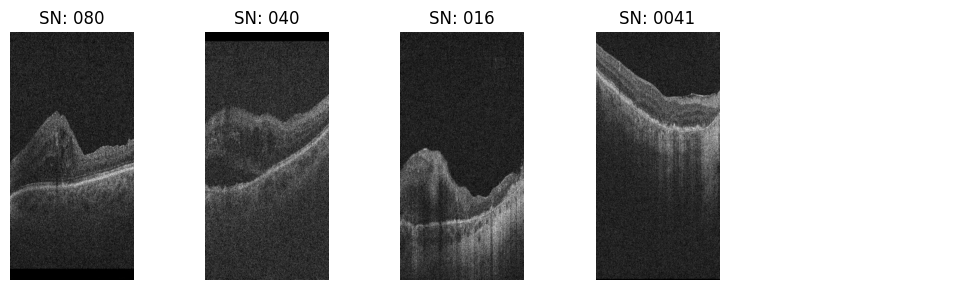

In [113]:
import shutil
import math

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_path = "best_VGG_model_1.pth"
model = load_model(model_path, device)
# === Define volume paths ===
volume_path_fovea = "C://Users//micah//OneDrive//Gmail OneDrive//Desktop//CMU//_Spring 2025//Projects in BME//Fovea or Not//potentially fovea"
volume_path_not_fovea = "C://Users//micah//OneDrive//Gmail OneDrive//Desktop//CMU//_Spring 2025//Projects in BME//Fovea or Not//potentially not fovea"

# === Run prediction on potentially fovea ===
test_loader_fovea = preprocess_image(volume_path_fovea, batch_size=1)
dest_dir_fovea = "predictions/potentially_fovea/"
save_txt_fovea = dest_dir_fovea + "class_1_predictions_potentially_fovea.txt"
os.makedirs(dest_dir_fovea, exist_ok=True)

print(f"Saving results at: {save_txt_fovea}")
model_prediction(model, test_loader_fovea, save_txt_fovea, volume_path_fovea, dest_dir_fovea)
show_result(volume_path_fovea, save_txt_fovea)

# === Run prediction on potentially not fovea ===
test_loader_not_fovea = preprocess_image(volume_path_not_fovea, batch_size=1)
dest_dir_not_fovea = "predictions/potentially_not_fovea/"
save_txt_not_fovea = dest_dir_not_fovea + "class_1_predictions_potentially_not_fovea.txt"
os.makedirs(dest_dir_not_fovea, exist_ok=True)

print(f"Saving results at: {save_txt_not_fovea}")
model_prediction(model, test_loader_not_fovea, save_txt_not_fovea, volume_path_not_fovea, dest_dir_not_fovea)
show_result(volume_path_not_fovea, save_txt_not_fovea)


In [115]:
def compute_accuracy_from_folders(pred_dir, expected_label):
    """
    pred_dir: Root predictions directory (e.g., "predictions/potentially_fovea/")
    expected_label: 1 if the source was fovea, 0 if not
    """
    fovea_folder = os.path.join(pred_dir, "predictions/fovea")
    no_fovea_folder = os.path.join(pred_dir, "predictions/no_fovea")

    num_fovea_preds = len(os.listdir(fovea_folder))
    num_no_fovea_preds = len(os.listdir(no_fovea_folder))
    total = num_fovea_preds + num_no_fovea_preds

    if total == 0:
        return 0.0  # Avoid division by zero

    if expected_label == 1:
        accuracy = num_fovea_preds / total
    else:
        accuracy = num_no_fovea_preds / total

    return accuracy

acc_fovea = compute_accuracy_from_folders(dest_dir_fovea, expected_label=1)
acc_not_fovea = compute_accuracy_from_folders(dest_dir_not_fovea, expected_label=0)

print(f"🟢 Accuracy on potentially fovea images:     {acc_fovea:.4f}")
print(f"🔵 Accuracy on potentially NOT fovea images: {acc_not_fovea:.4f}")


🟢 Accuracy on potentially fovea images:     0.8000
🔵 Accuracy on potentially NOT fovea images: 0.9658
